In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchtext as tt
import numpy as np
import math
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

ADD_DATA = False #whether to use augmented data
FORCE_BALANCE = False # whether to force balanced labels 

select_len = 300 #select only samples shorter than this
cut_off_len = 300 #cut off all samples to this length so they fit into memory


In [2]:
#take IMDB dataset (train and test), split into data and label, and adjust samples and labels according to parameters

ds_train, ds_test = tt.datasets.IMDB()

def separate(ds):
    ds_text = []
    ds_label = []
    for label,text in iter(ds):
        ds_text.append(text)
        ds_label.append(label)
    return ds_text,ds_label

ds_train_text, ds_train_label = separate(ds_train)

ds_test_text, ds_test_label = separate(ds_test)

print('full dataset average label',np.mean(ds_train_label))

#reduce dataset to short samples

#use the commented code to just select 2500 indices from the full dataset
#np.random.choice(range(len(ds_train_text)),size = 2500)
indices = [i for i in range(len(ds_train_text)) if len(ds_train_text[i]) < select_len] 

ds_train_text = [ds_train_text[i] for i in indices]
ds_train_label = [ds_train_label[i] for i in indices]

print('reduced dataset average label',np.mean(ds_train_label))

print('test dataset average label',np.mean(ds_test_label))

print('reduced dataset size',len(ds_train_text))

#add agumented data
if ADD_DATA:
    for line in open('./clean_data.out'):
        m = re.match(r'(1|2)\t(.*)',line) # match label<tab>text format
        if m:
            ds_train_text.append(m.group(2))
            ds_train_label.append(int(m.group(1)))
            
#enforce 50/50 balanced label
if FORCE_BALANCE:
    label_counts = [(ds_train_label.count(label),label) for label in np.unique(ds_train_label)]
    to_add_label_count, to_add_label = min(label_counts)
    target_count, _ = max(label_counts)
    num_to_add = target_count - to_add_label_count
    if num_to_add > 0:
        to_add_indices = [i for i in range(len(ds_train_text)) if ds_train_label[i] == to_add_label]
        chosen_indices = np.random.choice(to_add_indices,size = num_to_add)
        for i in chosen_indices:
            ds_train_text.append(ds_train_text[i])
            ds_train_label.append(ds_train_label[i])
        
        
    
print('final dataset size',len(ds_train_text))
print('final dataset average label',np.mean(ds_train_label))

full dataset average label 1.5
reduced dataset average label 1.5734536082474226
test dataset average label 1.5
reduced dataset size 776
final dataset size 776
final dataset average label 1.5734536082474226


In [3]:

#just disassemble the sentences into tokens
def yield_tokens(data_iter,tokenizer): 
    for text in data_iter: 
        yield tokenizer(text) 

#create vocab from data
def get_vocab(train_data,tokenizer): 
    vocab = tt.vocab.build_vocab_from_iterator(yield_tokens(train_data,tokenizer), 
                                     specials=['<UNK>', '<PAD>','<SOS>','<EOS>'], 
                                     max_tokens=50002) 
    vocab.set_default_index(vocab['<UNK>']) 
    return vocab 

#receives text and returns torch tensor and vocab.
#torch tensor is truncated text translated to token numbers according to vocab.
#if vocab is None then a vocabulary will be created based on the text
def process_dataset(text,vocab = None):
    
    tokenizer = tt.data.utils.get_tokenizer('basic_english')
    
    tokens = [['<SOS>']+tokenizer(s)+['<EOS>'] for s in text]
    
    if vocab == None:
        vocab = get_vocab(text,tokenizer)
    
    max_len = max([len(l) for l in tokens])
    
    pad = lambda x: x + ['<PAD>']*(max_len - len(x))
    
    data = torch.tensor([vocab.lookup_indices(pad(token_list)) for token_list in tokens],dtype=torch.int64)
    
    data = data[:,:cut_off_len]
    
    return data, vocab
    

    


In [4]:


ds_train_text,vocab = process_dataset(ds_train_text)
ds_train_label = torch.tensor(ds_train_label) - 1 #change labels to 0 and 1 for easier handling

ds_test_text,_ = process_dataset(ds_test_text,vocab)
ds_test_label = torch.tensor(ds_test_label) - 1

print(len(ds_train_text))

776


In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads  # here d is divided between the heads
        # each head has hidden dimension d
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesn't saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = torch.softmax(scores, dim=-1)  # (bs, n_heads, q_length, k_length)
        A = self.dropout(A)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size() # dim = embedding dimension

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        
        return H, A
    
"""
Feed Forward Network (FFN): an MLP with one hidden layer and ReLU activation applied to each and every element in the set.
"""
class FFN(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model, hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1)
        X = X / torch.pow(10_000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)
    
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, dropout=0):
        super().__init__()
        self.dropout = dropout
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = PositionalEncoding(num_hiddens=d_model, dropout=self.dropout,
                                                      max_len=max_position_embeddings)

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)
        self.d_model = d_model

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for the word embeddings and add them     
        embeddings = self.position_embeddings(word_embeddings) # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.ffn = FFN(d_model, conv_hidden_dim)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        
        # Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, dropout)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, self.dropout))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)
    
    
# Transormer classifier for sentiment analysis
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                                          maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x)
        x, _ = torch.max(x, dim=1)
        x = self.dense(x)
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2, 
                         conv_hidden_dim=128, input_vocab_size=len(vocab), num_answers=2)
model.to(device)

TransformerClassifier(
  (encoder): TransformerEncoder(
    (embedding): Embeddings(
      (word_embeddings): Embedding(5099, 32, padding_idx=1)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    )
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=False)
          (W_k): Linear(in_features=32, out_features=32, bias=False)
          (W_v): Linear(in_features=32, out_features=32, bias=False)
          (W_h): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): FFN(
          (k1convL1): Linear(in_features=32, out_features=128, bias=True)
          (k1convL2): Linear(in_features=128, out_features=32, bias=True)
          (activation): ReLU()
        )
        (layernorm1): LayerNorm((32,

In [6]:
batch_size = 128

ds_train = torch.utils.data.TensorDataset(ds_train_text, ds_train_label)
train_loader = torch.utils.data.DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)

ds_test = torch.utils.data.TensorDataset(ds_test_text, ds_test_label)
test_loader = torch.utils.data.DataLoader(dataset=ds_test, batch_size=batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 100
t_total = len(train_loader) * epochs

In [7]:
def evaluate(data_loader):
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    for x,y in data_loader:
        x = x.to(device)
        y = y.to(device)
                
        out = model(x)
        acc += (out.argmax(1) == y).cpu().numpy().mean()

    print(f"eval accuracy: {acc / nb_batches}")
    
    

def train(train_loader, eval_test = False):
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)

            loss = f.cross_entropy(out, y)
            
            optimizer.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()
                        
            train_acc += (out.argmax(1) == y).cpu().numpy().mean()
        
        train_accs.append(train_acc / nb_batches_train)
        
        if eval_test:
            nb_batches = len(test_loader)
            model.eval()
            acc = 0 
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                
                out = model(x)
                acc += (out.argmax(1) == y).cpu().numpy().mean()

            test_accs.append(acc / nb_batches)
        
        print(f"epoch {epoch}: train loss: {losses / nb_batches_train}")
        print(f"training accuracy: {train_acc / nb_batches_train}")
        
    return train_accs,test_accs

In [8]:
tr_acc,tt_acc = train(train_loader,True)

epoch 0: train loss: 0.7105688197272164
training accuracy: 0.5011160714285714
epoch 1: train loss: 0.6740985342434475
training accuracy: 0.6127232142857143
epoch 2: train loss: 0.6561356868062701
training accuracy: 0.625
epoch 3: train loss: 0.6669906207493373
training accuracy: 0.5859375
epoch 4: train loss: 0.6653157217161996
training accuracy: 0.5658482142857143
epoch 5: train loss: 0.6561638031687055
training accuracy: 0.6227678571428571
epoch 6: train loss: 0.6680947967938015
training accuracy: 0.5591517857142857
epoch 7: train loss: 0.6456559555871146
training accuracy: 0.6127232142857143
epoch 8: train loss: 0.6574503268514361
training accuracy: 0.6361607142857143
epoch 9: train loss: 0.6260430642536708
training accuracy: 0.6852678571428571
epoch 10: train loss: 0.6260592682021004
training accuracy: 0.609375
epoch 11: train loss: 0.6299690859658378
training accuracy: 0.640625
epoch 12: train loss: 0.6262664454323905
training accuracy: 0.7064732142857143
epoch 13: train loss: 0.6

In [9]:
evaluate(test_loader)

eval accuracy: 0.5475924744897959


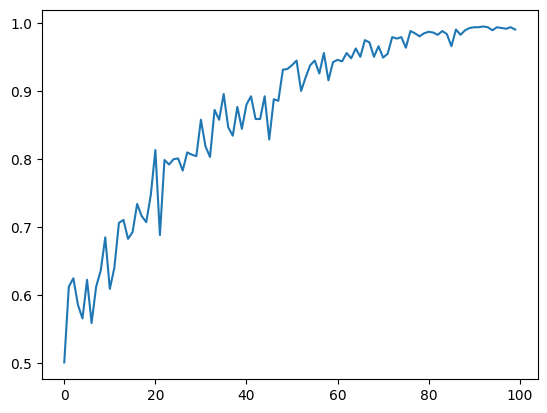

In [10]:
plt.plot(range(epochs),tr_acc)
plt.show()

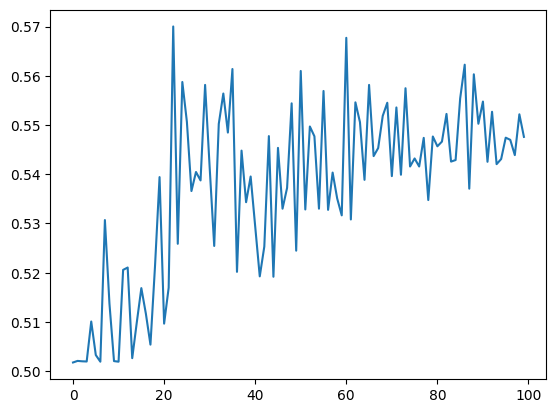

In [11]:
plt.plot(range(epochs),tt_acc)
plt.show()